# Analysis for CSKG's edge 
Gain insight from cskg's edge by analyzing its edge's relation between entities, analysis contains 5 parts:
* Lexicalize relation
* Represent each edge in a format like `edge_id   lexicalization   sentence`
* Compute sentence embeddings for sentence of each edge.
* Cluster sentence embedding
* Visualize clustering result

In [1]:
import os
import json 
from itertools import islice
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.contrib'

## Parameters for invoking the notebook

- `cskg_connected`: a tsv file contains the raw cskg entity information
- `cskg_lexicalized`: a tsv file contains the lexicalized edges
- `edge_embeddings.tsv.`: a tsv file contains the edges embeddings and edge id
- `log_path`: a folder keeps tensorboard projector's configuration

In [2]:
cskg_connected = '../input/cskg_connected.tsv'
cskg_lexicalized = '../output/cskg_lexicalized.tsv'
edge_embeddings = '../output/edge_embeddings.tsv'
log_path = '../output/log'

##  Load cskg_connected.tsv and retrieve useful information

In [3]:
### load cskg label and relation
def cskg_lexicalize(input_file): # cskg_connected.tsv   
    cskg_info = []
    with open(input_file) as f:
        for line in islice(f, 1, None): # ignore first line 
            content = line.split('\t')
            id_=  content[0]
            res_meta = content[2]
            node1_lbl = content[4]
            node2_lbl = content[5]
            res_lbl = content[6]
            
            reterive = lambda x: x.split('|')[0]
            node1_lbl = reterive(node1_lbl)
            node2_lbl = reterive(node2_lbl)
            res_lbl = reterive(res_lbl)
            
            if node1_lbl == '' or node2_lbl == '' or res_lbl== '':
                # if one of them is empty, then skip the edge
                continue                
            cskg_info.append((id_,node1_lbl,res_lbl,node2_lbl,res_meta))         
    return cskg_info 

# store res metadata and label infomation
def rel_info(cskg_info):
    rel_meta_dict = {}
    rel_lbl_dict = {}
    
    for line in cskg_info:
        rel_meta = line[-1]  # example: '/r/Is a'
        rel_label = line[2]  # example: 'is a '
        rel_lbl_dict[rel_label] = rel_lbl_dict.get(rel_label,0)+1
        rel_meta_dict[rel_meta] = rel_meta_dict.get(rel_meta,{})
        rel_meta_dict[rel_meta][rel_label] = rel_lbl_dict[rel_label]      
    return rel_meta_dict

In [4]:
cskg_info = cskg_lexicalize(cskg_connected)
print('edge_id, node1_label, relation_label, node2_label, , relation_meta')
print(cskg_info[0])
print(f'size of cskg_info: {len(cskg_info)}')

edge_id, node1_label, relation_label, node2_label, , relation_meta
('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', '0.22 inch calibre', 'is a', '5.6 millimetres', '/r/IsA')
size of cskg_info: 5957575


In [5]:
rel_meta_dict = rel_info(cskg_info)
print(f'relation size: {len(rel_meta_dict)}')
print(f"rel_meta_dict['/r/IsA']\n {rel_meta_dict['/r/IsA']}")

relation size: 80
rel_meta_dict['/r/IsA']
 {'is a': 242358, 'subproperty of': 1, 'subclass of': 47501, 'instance of': 26685}


In [6]:
relation_types = sorted(rel_meta_dict.items(),key=lambda x:len(x[1]),reverse=True)
# here you can see even if the relation labels belong to one relation meta type, these descrpitiona are various
len(relation_types[0][1]),relation_types[0]

(8752,
 ('/r/LocatedNear',
  {'has': 16438,
   'on': 27337,
   'on a': 1341,
   'in': 13550,
   'of': 7047,
   'of a': 1069,
   'of an': 60,
   'behind': 6378,
   'facing': 97,
   'carries': 66,
   'full of': 211,
   'of street': 2,
   'attaches to': 2,
   'black': 76,
   'has a': 8677,
   'doors on': 1,
   'made of': 843,
   'near': 2419,
   'horses head': 1,
   'attached to': 1417,
   'belonging to': 245,
   'license': 2,
   'end of': 11,
   'in middle has': 1,
   'being towed by': 1,
   'and': 1100,
   'out of': 39,
   'side of a': 1,
   'covered in': 336,
   'wheel': 1,
   'of a mans': 3,
   'of mans': 3,
   'says': 445,
   'have': 492,
   'connected to': 115,
   'are on': 1615,
   'showing on top of': 1,
   'hanging on': 319,
   'of sign': 1,
   'under': 1582,
   'truck': 1,
   'beside': 1157,
   'for': 2026,
   'with': 3486,
   'belongs to': 76,
   'visible on': 13,
   'close to': 86,
   'apart of': 46,
   'h': 3,
   'above': 3633,
   'yellow': 13,
   'mark on': 2,
   'on face of

## create template for cskg relations

In [7]:
rel_template = {
    '/r/IsA': 'is a',
    '/r/SimilarTo': 'is similar to',
    '/r/Synonym': 'is same as',
    '/r/Antonym': 'is opposite to',
    '/r/RelatedTo': 'is related to',
    '/r/FormOf': 'is form of',
    '/r/AtLocation': 'is located at',
    '/r/DerivedFrom': 'is derived from',
    '/r/HasProperty': 'has property',
    '/r/DefinedAs': 'is defined as',
    '/r/EtymologicallyRelatedTo': 'is etymologically related to',
    '/r/InstanceOf': 'is a', # == '/r/IsA'
    '/r/dbpedia/genre': 'is a type of',
    '/r/CapableOf': 'is able to',
    '/r/PartOf': 'is a part of',
    '/r/MadeOf': 'is made of',
    '/r/ReceivesAction': 'can receive the action',
    '/r/HasA': 'has a',
    '/r/UsedFor': 'is used for',
    '/r/NotHasProperty': 'not has property',
    '/r/CausesDesire': 'causes desire to',
    '/r/dbpedia/occupation': 'occupation is', # career
    '/r/dbpedia/language': 'language is',
    '/r/HasSubevent': 'can have event',
    '/r/HasContext':'has context',
    '/r/LocatedNear':'is located near', ## .... lots of subpro .. shall I need to tag for each one?
    '/r/DistinctFrom': 'is different from',
    '/r/dbpedia/influencedBy': 'is influenced by',
    '/r/MannerOf': 'is manner of',
    'mw:MayHaveProperty': 'may have property', # similar to has property
    '/r/Entails': 'entails', # similat to cause
    '/r/dbpedia/field': 'belongs to field of',
    '/r/dbpedia/genus': 'belongs to genus of',
    '/r/HasPrerequisite': 'has prerequisite of',
    '/r/dbpedia/capital':"capital is",
    '/r/NotCapableOf': 'is not able to',
    '/r/dbpedia/product': 'is product of',
    '/r/MotivatedByGoal': 'is motivated by goal',
    '/r/Desires': 'desire to',
    '/r/Causes':'causes',
    '/r/HasFirstSubevent': 'starts with',
    '/r/HasLastSubevent': 'ends with',
    '/r/NotDesires': 'doest not desire to',
    '/r/dbpedia/knownFor':'is known for',
    '/r/CreatedBy': 'is created by',
    '/r/dbpedia/leader': 'has the leader',
    '/r/EtymologicallyDerivedFrom': 'is etymologically derived from',
    '/r/SymbolOf': 'is symbol of', # similar to 'is'
    'at:xAttr': 'has attribute',
    'at:xEffect': 'causes', # same as  '/r/Causes'
    'at:xIntent': 'wants to',
    'at:xReact':'feels',
    'at:xWant': 'wants to',
    'at:oReact': 'feels',
    'at:oWant': 'wants to',
    'at:xNeed' : 'needs',
    'at:oEffect': 'causes',
    'fn:HasFrameElement':'has frame element',
    'fn:HasLexicalUnit': 'has lexical unit',
    'fn:InheritsFrom': 'inherits from',
    'fn:IsInheritedBy' : 'is inherited by',
    'fn:IsUsedBy': 'is used by',
    'fn:PerspectiveOn': 'has perspective on',
    'fn:Uses': 'uses',
    'fn:IsPerspectivizedIn': 'is perspectivized in',
    'fn:Precedes':'precedes',
    'fn:SubframeOf': 'is subframe of',
    'fn:IsPrecededBy': 'is preceded by',
    'fn:ReframingMapping': 'reframing mapping',
    'fn:HasSubframe': 'has subframe',
    'fn:SeeAlso': 'see also',
    'fn:IsCausativeOf': 'causes', # same as  '/r/Causes'
    'fn:IsInchoativeOf': 'is inchoative of', # a little bit like 'cause'
    'fn:Metaphor': 'is similar to', # same as similar to
    'fn:HasSemType': 'has sem type', # same type???
    'fn:fe:ExcludesFE': 'excludes fe',# ?
    'fn:fe:RequiresFE': 'requires fe',
    'fn:st:RootType': "root type is",
    'fn:st:SuperType': "super type is",
    'fn:st:SubType': "sub type is",
}

##  Represent each of the edges in TSV format
    * edge_id   lexicalization   sentence   
    
puzzle : which format shoud I use? {edge_id}    lexicalization   {sentence} or edge_id   lexicalization   sentence   

In [8]:
def create_cskg_lexi(cskg_info,rel_template,output_file):
    edge_info = []
    with open(output_file,'w') as f:  
        # format for cskg_info : edge_id, node1_label, relation_label, node2_label, , relation_meta
        for edge in cskg_info:
            edge_id = edge[0] 
            node1_label = edge[1]
            node2_label = edge[3]
            res_meta = edge[4] 
            lexicalization = rel_template[res_meta]
            sentence =  node1_label + ' ' + lexicalization + ' '  + node2_label
            
            f.write(f"{edge_id}\t")  #  f.write(f"{{{edge_id}}}\t")
            f.write(f"{lexicalization}\t")
            f.write(f"{sentence}\n")  # f.write(f"{{{sentence}}}\n")
            edge_info.append((edge_id,lexicalization,sentence))
    return edge_info

In [9]:
edge_info = create_cskg_lexi(cskg_info,rel_template,cskg_lexicalized)
print('edge_id\tlexicalization\tsentence')
print(edge_info[0])

edge_id	lexicalization	sentence
('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', 'is a', '0.22 inch calibre is a 5.6 millimetres')


## Compute sentence embeddings for sentence of each edge
 * model usage: bert-nli-large model
 * data usage: cskg_lexicalized

In [10]:
# use the pre-trained model bert-base-nli-mean-tokens
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [11]:
# prepare all sentences
sentences = [i[-1] for i in edge_info]
sentences[0]

'0.22 inch calibre is a 5.6 millimetres'

In [12]:
%%time
# opearate sentence embedding
sentence_embeddings = model.encode(sentences)

CPU times: user 1h 1min 23s, sys: 4min 58s, total: 1h 6min 21s
Wall time: 1h 6min 22s


In [13]:
# output embedding result
def gen_edge_embed(edge_info, sentence_embeddings,output_file):
    # format edge_id   edge-embedding   embedding
    edge_embedding = []
    fout = open(output_file,'w')   
    tag = 'edge-embedding'
    for edge, embedding in zip(edge_info, sentence_embeddings):
        id_ = edge[0]
        value = [str(float(i)) for i in embedding]
        value = ','.join(value)
        fout.write(id_+'\t')
        fout.write(tag+'\t')
        fout.write(value+'\n') 
        edge_embedding.append((id_,embedding))
        
    fout.close()
    return edge_embedding

In [14]:
%%time 
edge_embedding = gen_edge_embed(edge_info, sentence_embeddings,edge_embeddings)

CPU times: user 1h 21min 1s, sys: 3min 18s, total: 1h 24min 19s
Wall time: 1h 31min 40s


In [18]:
edge_embedding[0][1].shape,edge_embedding[0]

((768,),
 ('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000',
  array([ 1.58931106e-01,  3.31045777e-01,  6.88741729e-02,  4.79571521e-01,
          8.45619202e-01,  3.47048372e-01,  2.99401700e-01,  2.13253543e-01,
         -5.05213261e-01,  2.70479590e-01,  1.36859030e-01, -2.18264729e-01,
          5.41408181e-01,  1.07267380e+00,  5.34212708e-01,  5.12835920e-01,
         -2.71607250e-01,  6.24554336e-01,  1.99282452e-01, -3.30278069e-01,
         -4.67047840e-01,  6.26949906e-01, -6.60365298e-02,  6.90974072e-02,
         -5.43774702e-02,  7.36368835e-01,  5.50401509e-01, -1.61804283e+00,
         -3.42321277e-01, -2.58626550e-01,  1.51696205e-01,  1.25676319e-01,
          3.86696666e-01,  2.27367297e-01,  1.22095478e+00, -6.91241860e-01,
         -1.03407967e+00,  3.70540351e-01,  1.23992607e-01, -6.21091604e-01,
          1.21859515e+00, -7.51353204e-01,  6.32800162e-02,  1.31648734e-01,
         -1.43425262e+00, -5.43942213e-01,  9.06557918e-01, -1.20478325e-01,
    

## Cluster edges 

In [19]:
# build training data 
edge_list = [edge[0] for edge in edge_embedding]  # keep each edge's id
X_train = [edge[1] for edge in edge_embedding]    # keep each edge's embeddings

In [20]:
%%time
#fit the model
model = KMeans(n_clusters=13,init='k-means++',verbose=0)
model.fit(X_train)
pred_labels = model.labels_

CPU times: user 5h 41min 31s, sys: 13min 54s, total: 5h 55min 26s
Wall time: 31min 26s


In [21]:
## summarize the cluster result
label_dict = {}
edge_num = len(pred_labels)
for label in pred_labels:
    label_dict[label] = label_dict.get(label,0)+1/edge_num
label_dict

{9: 0.04886719848290374,
 6: 0.058214458064372504,
 11: 0.10923404237415023,
 1: 0.07769688170125244,
 0: 0.06892737397388972,
 7: 0.08230580395559114,
 3: 0.11238868163586054,
 12: 0.09851441232356997,
 10: 0.10867206875234507,
 5: 0.04825906514004703,
 8: 0.07005937818698828,
 2: 0.05342861818815656,
 4: 0.06343201722231295}

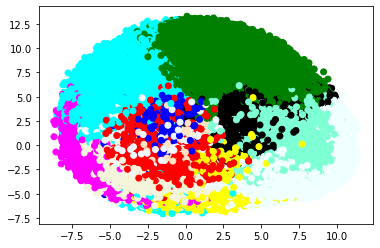

In [22]:
## Use pca to do dimension reduction and visualize the result (the performance is not very good)
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_train)

colors=['blue','green','red','cyan','magenta','yellow','black','aliceblue',
        'aqua','aquamarine','beige','azure','bisque']

col_map=dict(zip(set(pred_labels),colors))
label_color = [col_map[l] for l in pred_labels]

plt.scatter( X_pca[:,0], X_pca[:,1],c=label_color)
plt.show() 

## Use tensorflow projector to display visualization

In [27]:
def visualisation(edge_ids, embeddings, log_path):
    if not os.path.exists(log_path):
        os.mkdir(log_path)

    with tf.Session() as sess:
        # assign embeddings to tf var
        x = tf.Variable([0.0], name='edge_embedding')
        place = tf.placeholder(tf.float32, shape=[len(edge_ids), len(embeddings[0])])

        set_x = tf.assign(x, place, validate_shape=False)
        sess.run(tf.global_variables_initializer())
        sess.run(set_x, feed_dict={place: embeddings})

        # store metedata to log path
        with open(log_path + '/metadata.tsv', 'w') as f:
            f.write('Edge ID\tCluster\n')
            for edge in edge_ids:
                edge_id = edge[0]
                edge_clusetr = edge[1]
                f.write(str(edge_id) + '\t' + str(edge_clusetr)+'\n' )

        # summary writing
        summary_writer = tf.summary.FileWriter(log_path)   
        # projector configuration
        config = projector.ProjectorConfig()
        emb_conf = config.embeddings.add()
        emb_conf.tensor_name = x.name
        emb_conf.metadata_path = 'metadata.tsv'
        projector.visualize_embeddings(summary_writer, config)
        # save model.ckpt
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(log_path, 'model.ckpt'), 1)

In [24]:
# wrap edge embeddings 
embeddings = []
edge_ids = []
for inde,edge in enumerate(edge_embedding):
    pred_label = pred_labels[inde]
    embeddings.append(edge[1]) 
    edge_ids.append((edge[0],pred_label))
    
embeddings = np.array(embeddings)
embeddings.shape,edge_ids[0]

((5957575, 768),
 ('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', 9))

After executing the following code, a `log` folder will be generated automatically, then you use `tensorboard --logdir=log_path` to check visualization

In [28]:
visualisation(edge_ids, embeddings, log_path)

Here is the result when using t-sne algorithm for clustering after 500 iterations
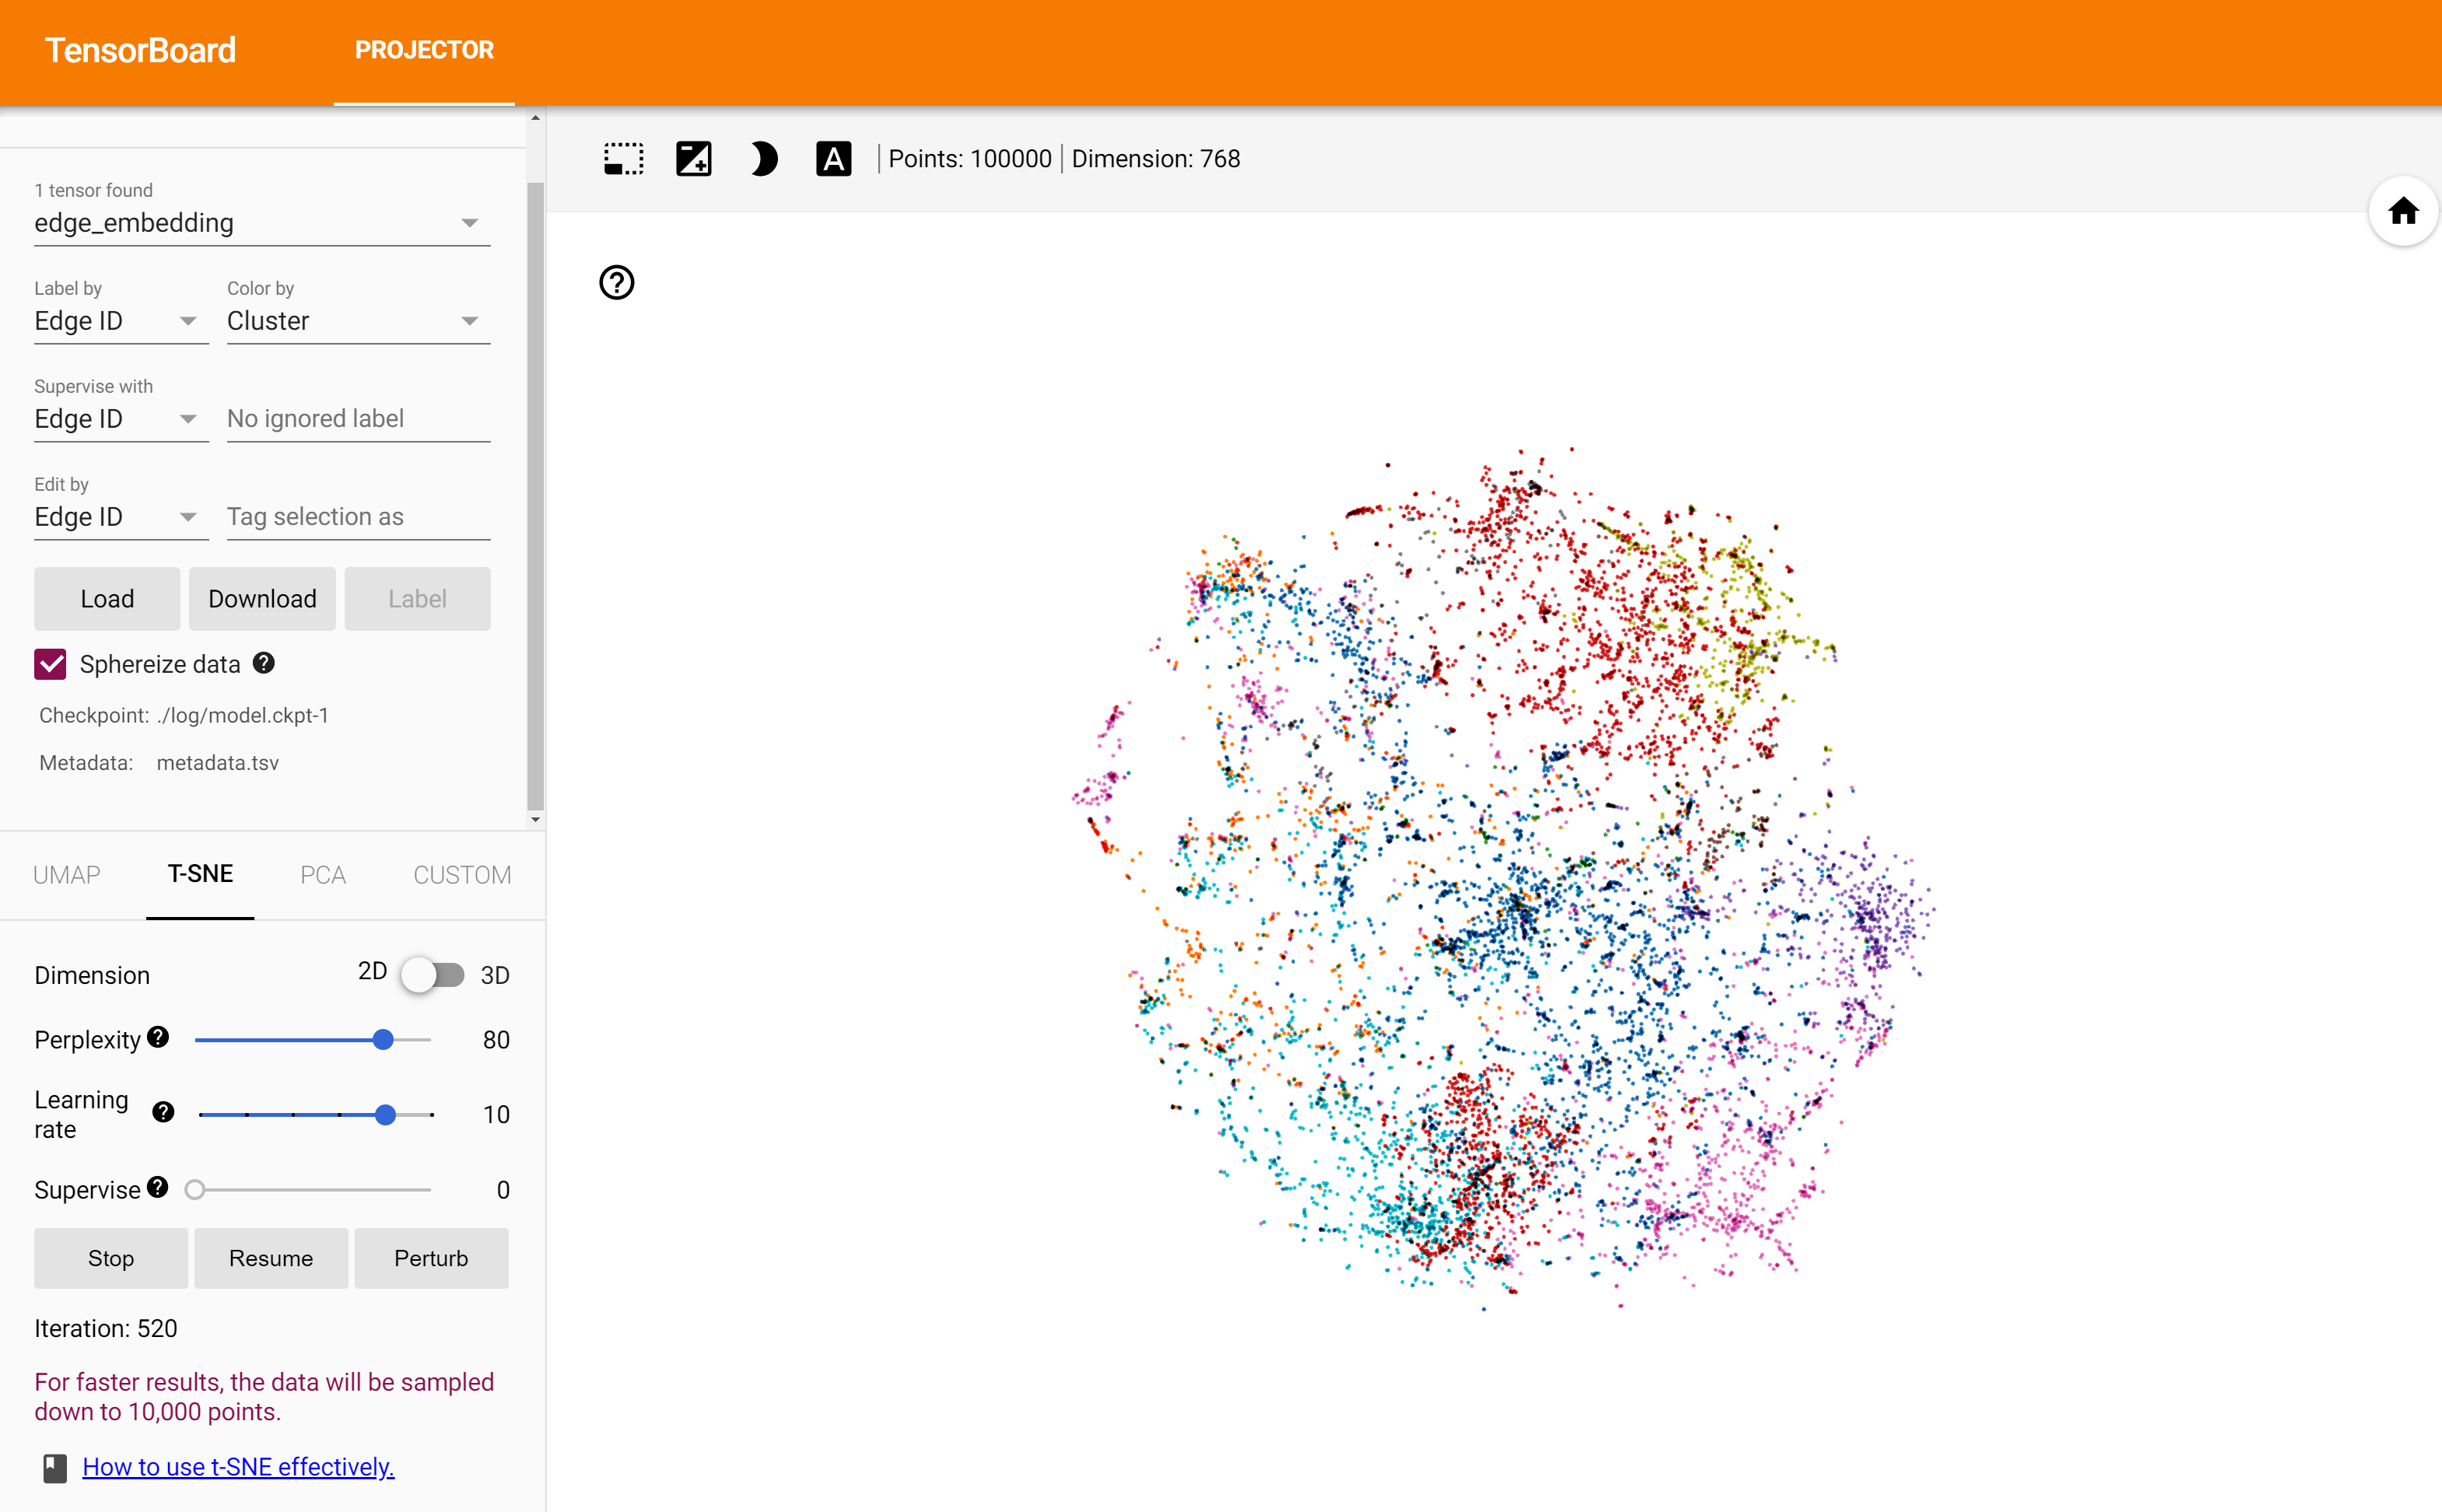